In [ ]:
# google colab の実行環境にデータをダウンロード (下の行のコメントアウトを外して実行してください)
# !wget https://raw.githubusercontent.com/KHiraGit/suds2503/refs/heads/main/london_merged.csv

In [50]:
# 1. ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 2. データセットの読み込み
url = "london_merged.csv"
df = pd.read_csv(url)

# 日時データの処理 (日付のデータ型を変更、時と曜日の列を作成)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df = df.sort_values('timestamp')

In [7]:
# データの概要(先頭)を表示
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6


In [6]:
# データの概要(末尾)を表示
df.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,19,1
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,20,1
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,21,1
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,22,1
17413,2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0,23,1


In [ ]:
# データの基本情報を表示
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[us]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  hour          17414 non-null  int32         
 11  day_of_week   17414 non-null  int32         
dtypes: datetime64[us](1), float64(8), int32(2), int64(1)
memory usage: 1.5 MB


In [ ]:
# データの欠損を確認
print(df.isnull().sum())

欠損値の数:
timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
hour            0
day_of_week     0
dtype: int64


In [10]:
# データの統計的概要を表示
df.describe()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week
count,17414,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.00000
mean,2016-01-03 22:31:00.571953,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075,11.513265,2.99265
min,2015-01-04 00:00:00,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2015-07-04 20:15:00,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000,6.000000,1.00000
50%,2016-01-03 15:30:00,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000,12.000000,3.00000
75%,2016-07-04 15:45:00,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000,18.000000,5.00000
max,2017-01-03 23:00:00,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000,23.000000,6.00000
std,NaN,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911,6.915893,2.00406


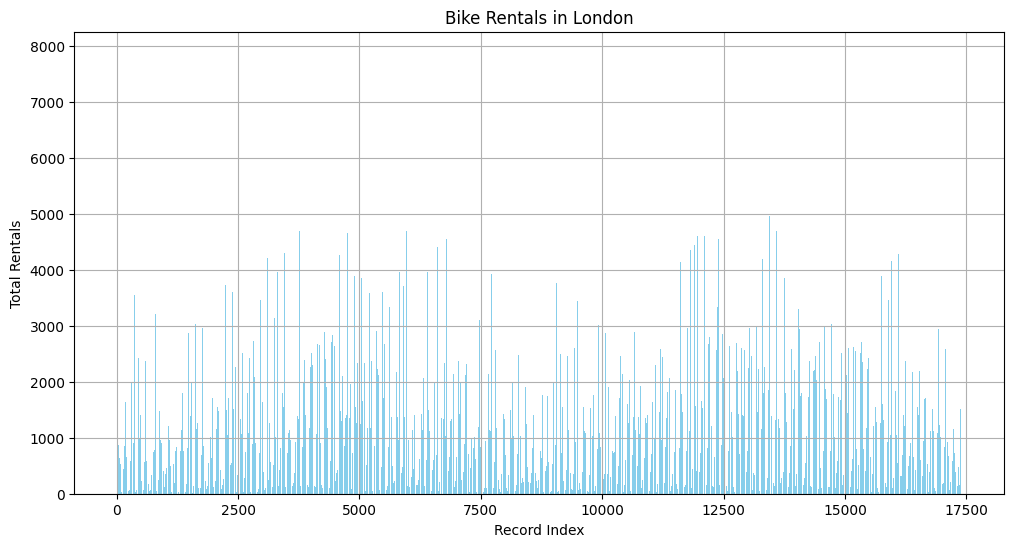

In [59]:
# 利用数の推移をプロット
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['cnt'], color='skyblue')
plt.title('Bike Rentals in London')
plt.xlabel('Record Index')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

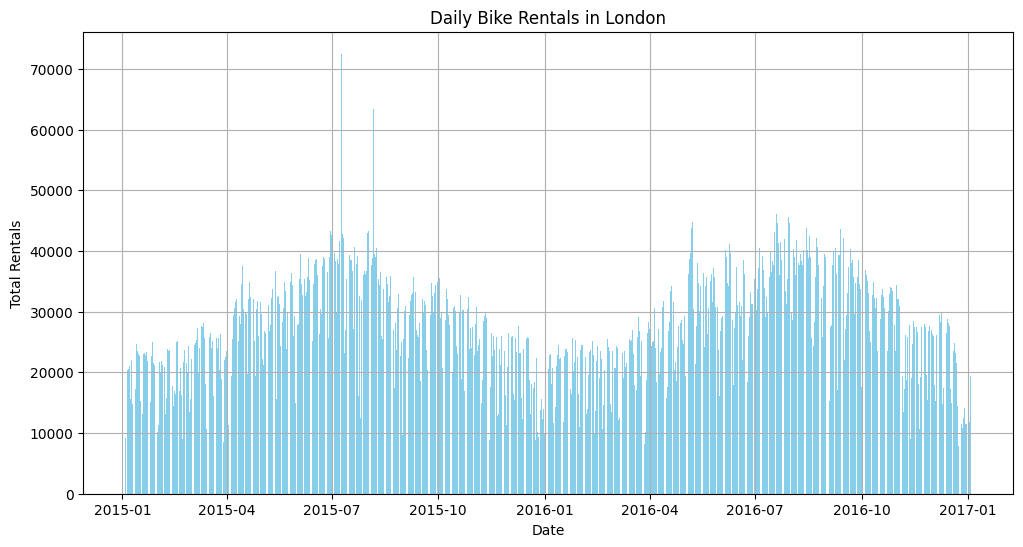

In [63]:
# 日別の利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_month = df.set_index('timestamp')['cnt'].resample('D').sum()
plt.bar(df_month.index, df_month.values, color='skyblue')
plt.title('Daily Bike Rentals in London')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

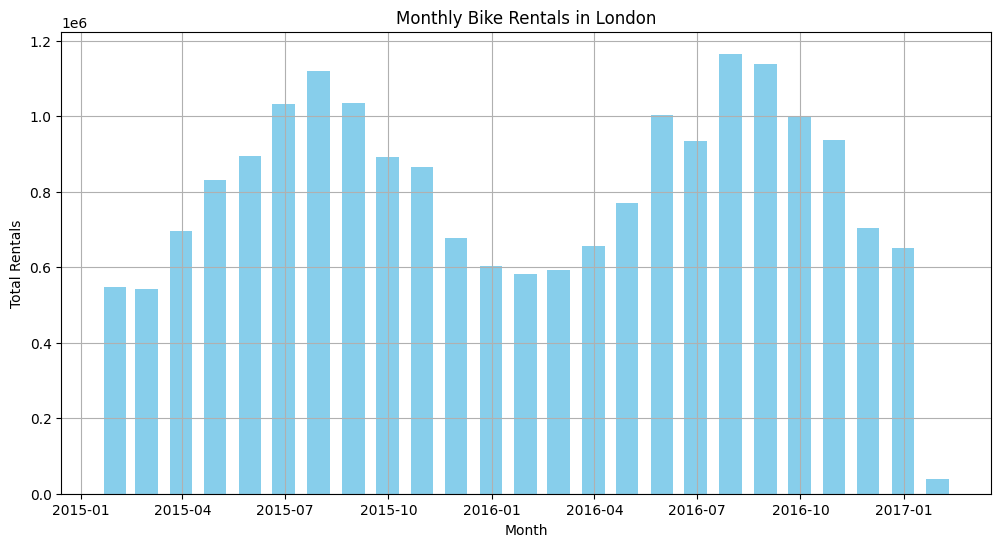

In [17]:
# 月別の利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_month = df.set_index('timestamp')['cnt'].resample('ME').sum()
plt.bar(df_month.index, df_month.values, width=20, color='skyblue')
plt.title('Monthly Bike Rentals in London')
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.grid()
plt.show()

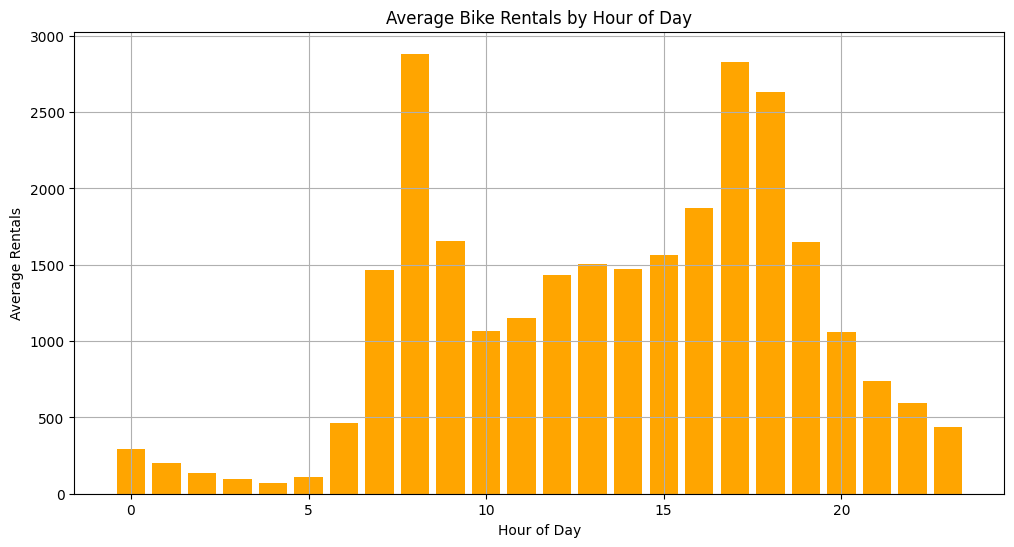

In [22]:
# 時間ごとの利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_hour = df.groupby('hour')['cnt'].mean()
plt.bar(df_hour.index, df_hour.values, color='orange')
plt.title('Average Bike Rentals by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

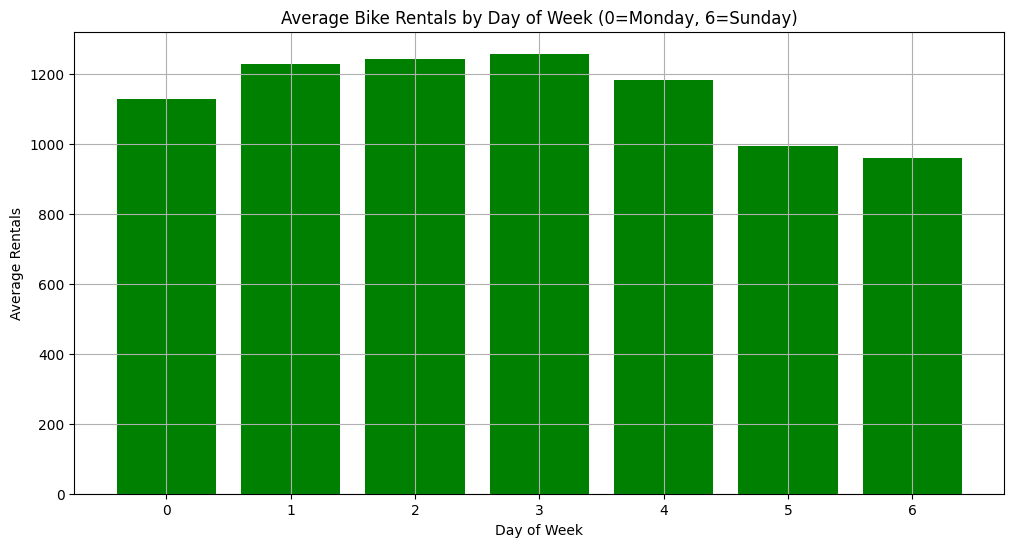

In [35]:
# 曜日ごとの利用数の推移をプロット
plt.figure(figsize=(12, 6))
df_hour = df.groupby('day_of_week')['cnt'].mean()
plt.bar(df_hour.index, df_hour.values, color='green')
plt.title('Average Bike Rentals by Day of Week (0=Monday, 6=Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

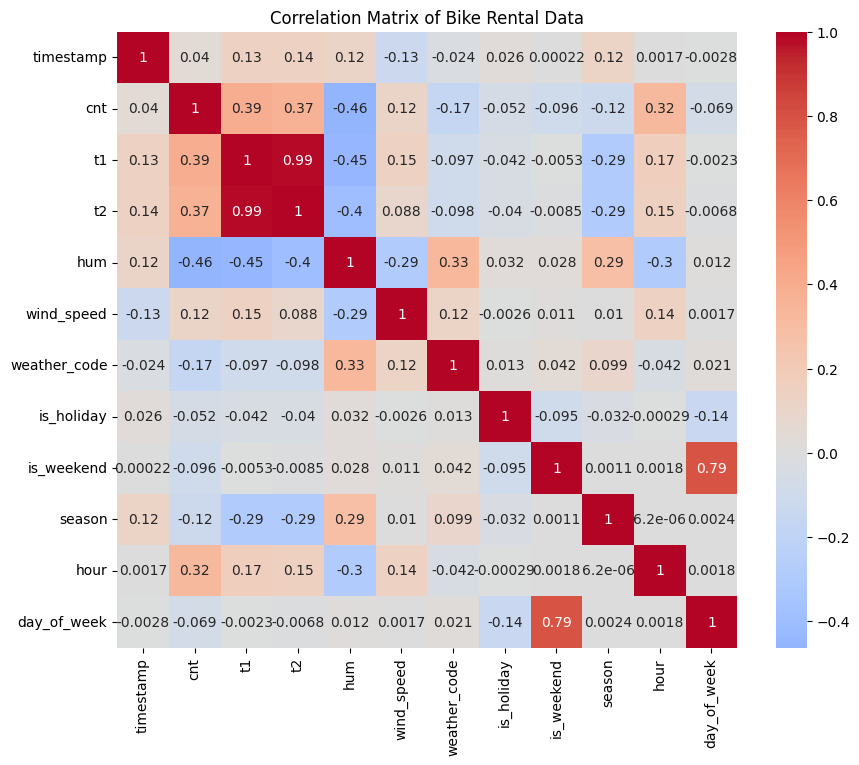

In [ ]:
# データの相関行列を作成して、ヒートマップで表示
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Bike Rental Data')
plt.show()

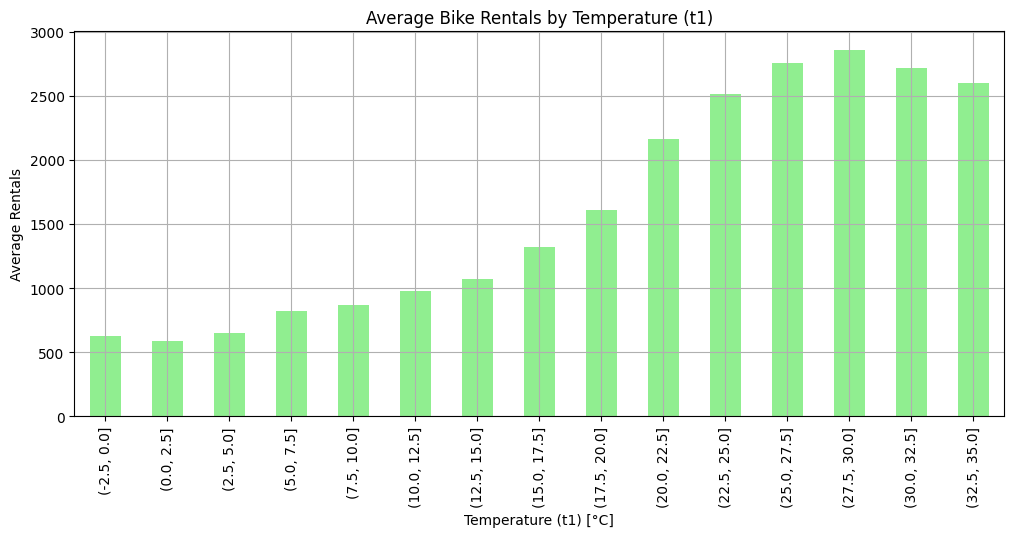

In [ ]:
# 気温t1を5度ごとでcntを集計し、棒グラフで表示
plt.figure(figsize=(12, 5))
df_temp = df.groupby(pd.cut(df['t1'], bins=np.arange(-5, 40, 2.5)))['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Temperature (t1)')
plt.xlabel('Temperature (t1) [°C]')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

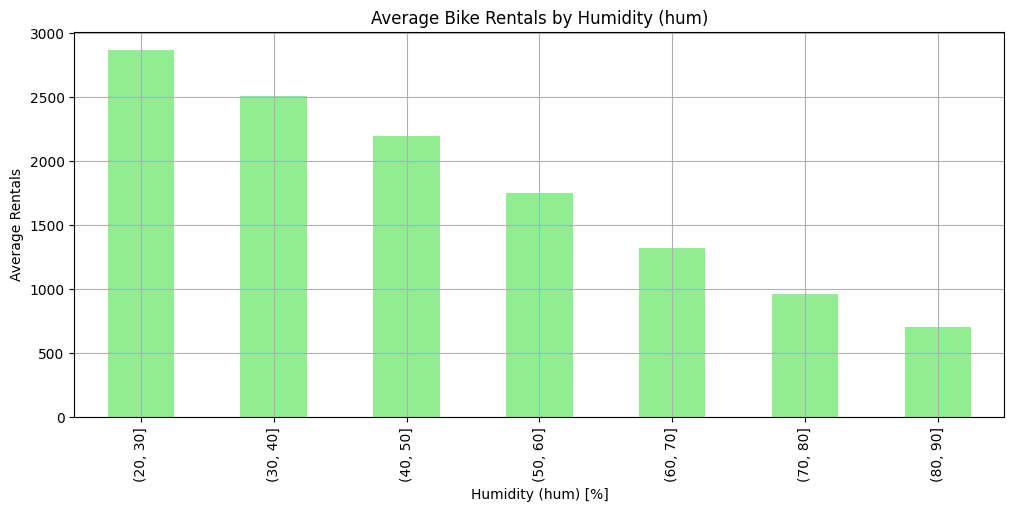

In [36]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# 湿度humを10%ごとにcntを集計し、棒グラフで表示
df_temp = df.groupby(pd.cut(df['hum'], bins=np.arange(0, 100, 10)))['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Humidity (hum)')
plt.xlabel('Humidity (hum) [%]')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

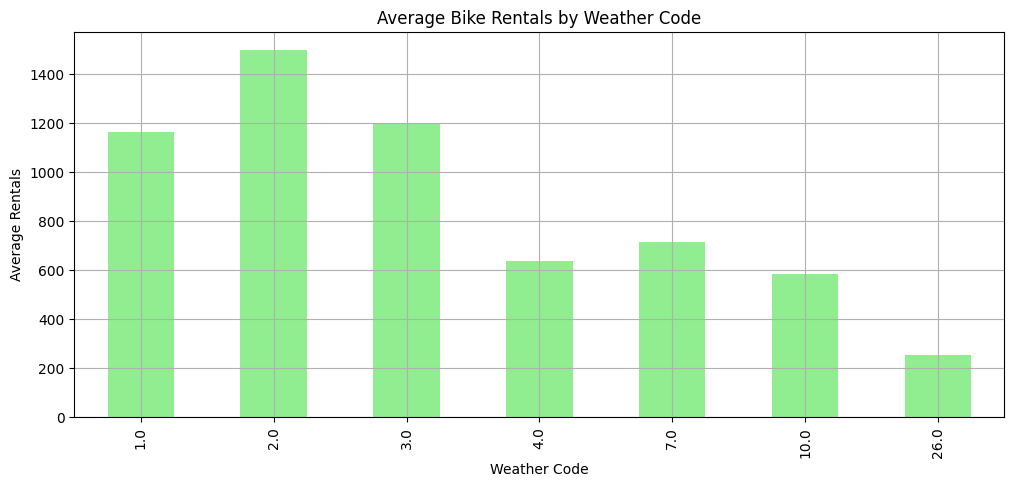

In [ ]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# weather_codeごとにcntを集計し、棒グラフで表示
# 天候コード 1=快晴 2=晴れ（雲が点在） 3=晴れ（切れ切れの雲） 4=曇り 7=雨/小雨/弱い雨 10=雷雨を伴う雨 26=降雪 94=凍結霧
df_temp = df.groupby('weather_code')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Weather Code')
plt.xlabel('Weather Code')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

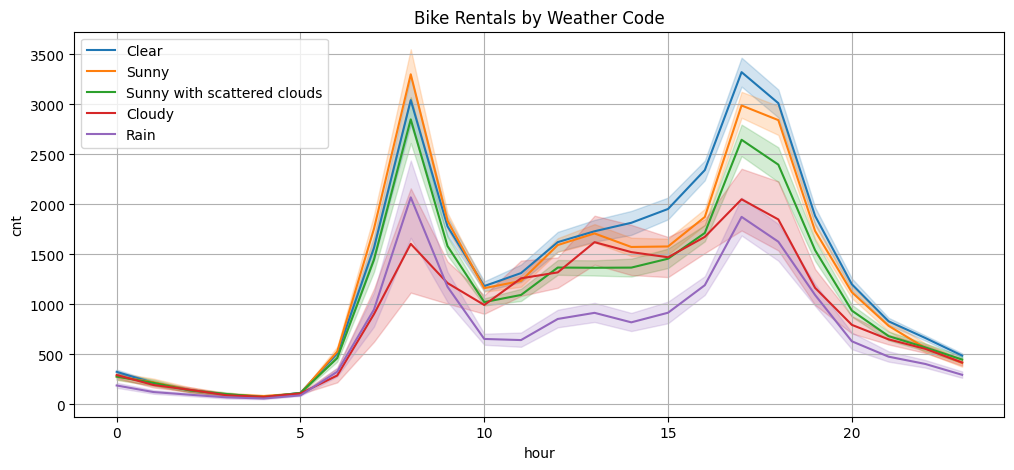

In [46]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# weather_codeごとの利用パターンの違い
sns.lineplot(data=df[df['weather_code'] == 1], x='hour', y='cnt', label='Clear')
sns.lineplot(data=df[df['weather_code'] == 2], x='hour', y='cnt', label='Sunny')
sns.lineplot(data=df[df['weather_code'] == 3], x='hour', y='cnt', label='Sunny with scattered clouds')
sns.lineplot(data=df[df['weather_code'] == 4], x='hour', y='cnt', label='Cloudy')
sns.lineplot(data=df[df['weather_code'] == 7], x='hour', y='cnt', label='Rain')
# sns.lineplot(data=df[df['weather_code'] == 10], x='hour', y='cnt', label='Thunderstorm')
# sns.lineplot(data=df[df['weather_code'] == 26], x='hour', y='cnt', label='Snow')
plt.title('Bike Rentals by Weather Code')
plt.grid(True)
plt.show()

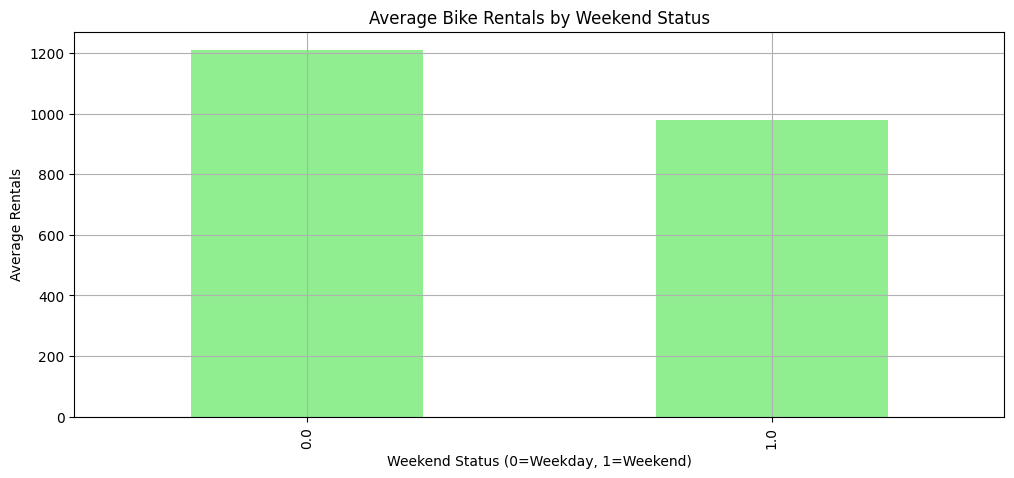

In [39]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# is_weekendにcntを集計し、棒グラフで表示
# is_weekend 0=平日 1=週末
df_temp = df.groupby('is_weekend')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Weekend Status')
plt.xlabel('Weekend Status (0=Weekday, 1=Weekend)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

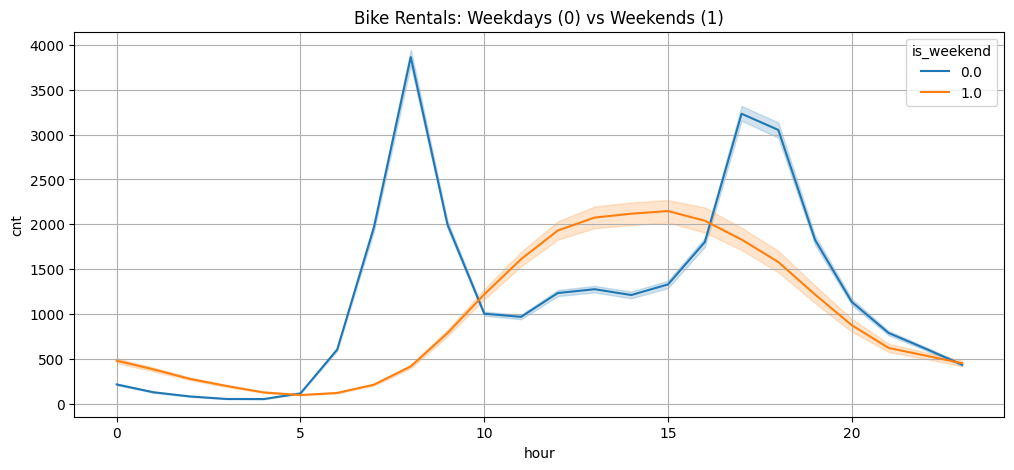

In [ ]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# 平日と休日の利用パターンの違い
sns.lineplot(data=df, x='hour', y='cnt', hue='is_weekend')
plt.title('Bike Rentals: Weekdays (0) vs Weekends (1)')
plt.grid(True)
plt.show()

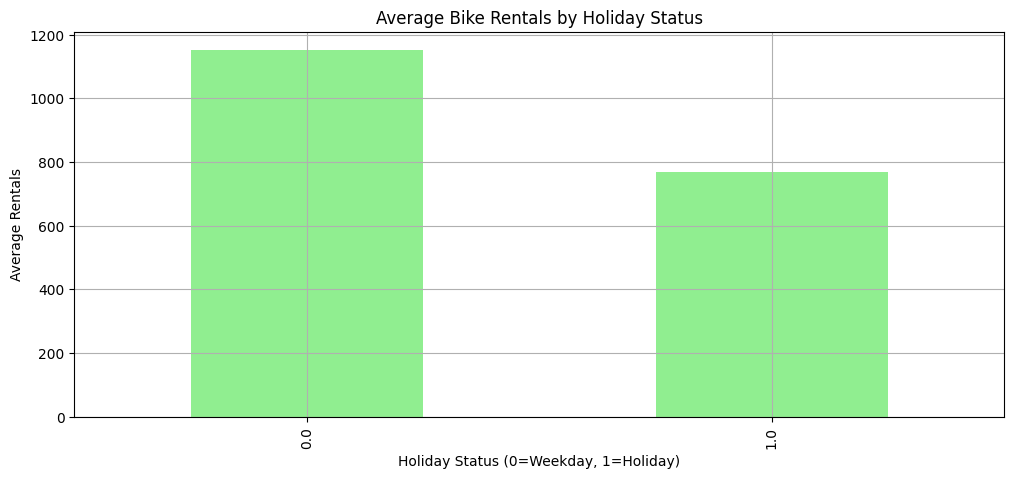

In [40]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# is_holidayでcntを集計し、棒グラフで表示
# is_holiday 0=平日 1=祝日
df_temp = df.groupby('is_holiday')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Holiday Status')
plt.xlabel('Holiday Status (0=Weekday, 1=Holiday)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

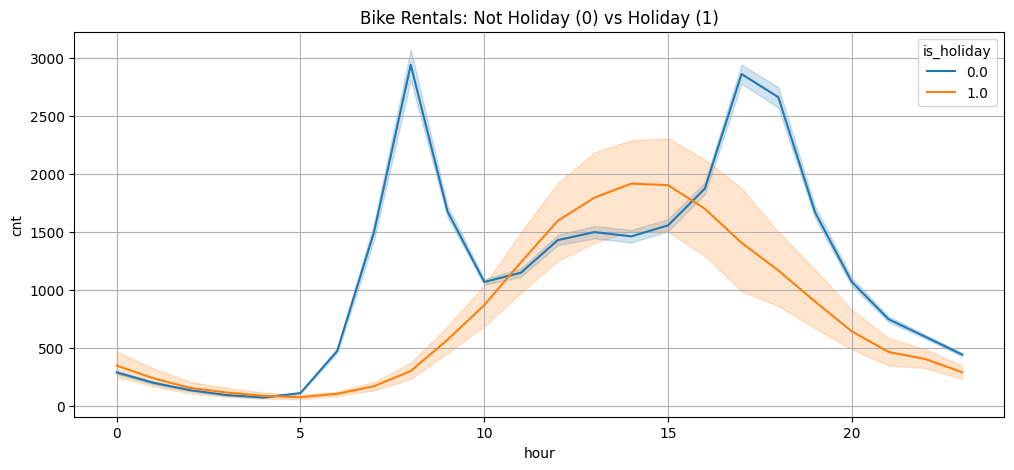

In [24]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# 祝日の利用パターン
sns.lineplot(data=df, x='hour', y='cnt', hue='is_holiday')
plt.title('Bike Rentals: Not Holiday (0) vs Holiday (1)')
plt.grid(True)
plt.show()

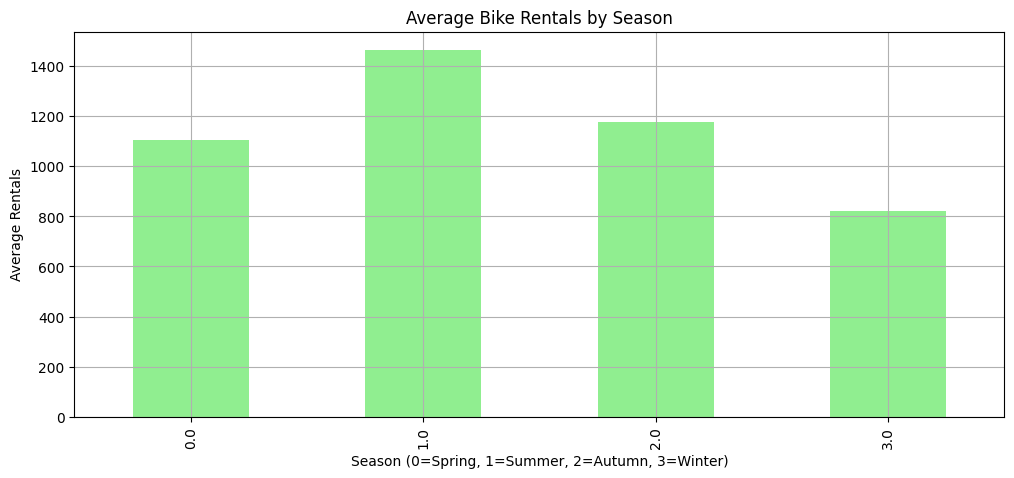

In [41]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# seasonでcntを集計し、棒グラフで表示
# season: 0=春　1=夏　2=秋　3=冬
df_temp = df.groupby('season')['cnt'].mean()
df_temp.plot(kind='bar', color='lightgreen')
plt.title('Average Bike Rentals by Season')
plt.xlabel('Season (0=Spring, 1=Summer, 2=Autumn, 3=Winter)')
plt.ylabel('Average Rentals')
plt.grid()
plt.show()

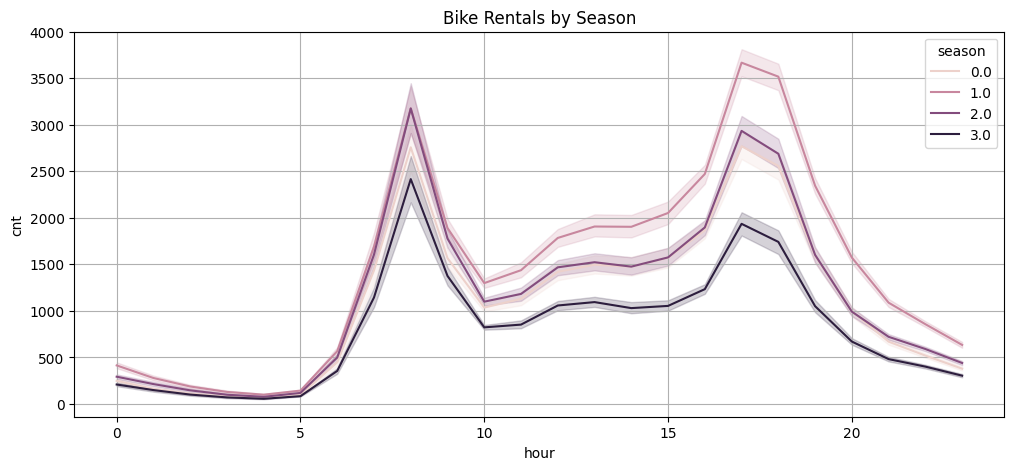

In [42]:
# 3. データの可視化（現場の感覚をデータで確認）
plt.figure(figsize=(12, 5))
# 季節ごとの利用パターン
sns.lineplot(data=df, x='hour', y='cnt', hue='season')
plt.title('Bike Rentals by Season')
plt.grid(True)
plt.show()

In [80]:
# 利用数を予測するための線形モデルを作成し、精度を検証
df_tmp = df.copy()

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）を使用
X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday','season']]
y = df_tmp['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 線形回帰モデルを作成
model = LinearRegression()
model.fit(X_train, y_train)
# テストデータで予測
y_pred = model.predict(X_test)
# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

All Hours: Mean Absolute Error: 698.13 Mean Squared Error: 898432.45 R2 Score: 0.25


In [ ]:
# 各時刻の利用数を予測するための線形モデルを作成し、精度を検証
for _hour in range(24):
    # _hourのデータを抽出
    df_tmp = df.query(f'hour == {_hour}')

    # dfを学習用とテスト用に分割
    # 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）を使用
    X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday','season']]
    y = df_tmp['cnt'] # 目的変数
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 線形回帰モデルを作成
    model = LinearRegression()
    model.fit(X_train, y_train)
    # テストデータで予測
    y_pred = model.predict(X_test)
    # 各種評価指標を計算
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{_hour}: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

0: Mean Absolute Error: 69.97 Mean Squared Error: 9807.91 R2 Score: 0.70
1: Mean Absolute Error: 58.61 Mean Squared Error: 7554.24 R2 Score: 0.69
2: Mean Absolute Error: 33.64 Mean Squared Error: 2064.54 R2 Score: 0.79
3: Mean Absolute Error: 24.96 Mean Squared Error: 1234.63 R2 Score: 0.78
4: Mean Absolute Error: 17.44 Mean Squared Error: 614.65 R2 Score: 0.68
5: Mean Absolute Error: 17.35 Mean Squared Error: 741.15 R2 Score: 0.47
6: Mean Absolute Error: 71.40 Mean Squared Error: 15236.38 R2 Score: 0.80
7: Mean Absolute Error: 194.58 Mean Squared Error: 78204.70 R2 Score: 0.91
8: Mean Absolute Error: 359.61 Mean Squared Error: 338121.10 R2 Score: 0.90
9: Mean Absolute Error: 194.25 Mean Squared Error: 78300.50 R2 Score: 0.84
10: Mean Absolute Error: 152.23 Mean Squared Error: 50361.17 R2 Score: 0.54
11: Mean Absolute Error: 212.84 Mean Squared Error: 86515.88 R2 Score: 0.68
12: Mean Absolute Error: 284.74 Mean Squared Error: 146016.45 R2 Score: 0.65
13: Mean Absolute Error: 304.25 Mea

[ 2.30665859e+01 -2.16472731e-01 -9.57099266e+00 -1.35766972e+01
 -1.80274006e+03 -1.79084266e+03 -5.98029283e+01]


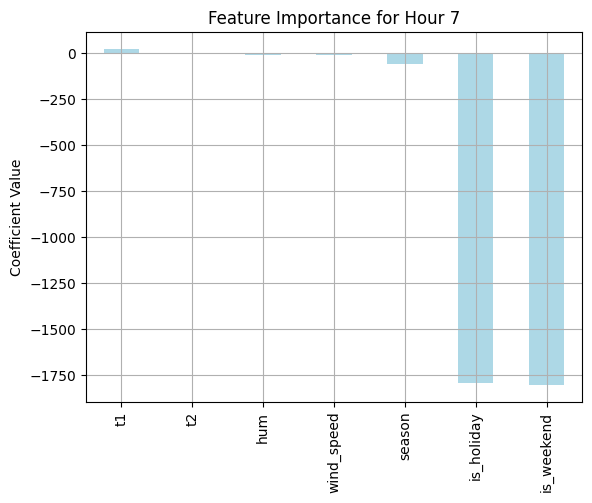

In [68]:
# 最も予測精度が高かった7時のモデルにおいて、特徴量の重要度を確認
_hour = 7
# _hourのデータを抽出
df_tmp = df.query(f'hour == {_hour}')

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）を使用
X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday','season']]
y = df_tmp['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 線形回帰モデルを作成
model = LinearRegression()
model.fit(X_train, y_train)

# 特徴量の重要度を表示
print(model.coef_)
feature_importance = pd.Series(model.coef_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance for Hour 7')
plt.ylabel('Coefficient Value')
plt.grid()
plt.show()

In [65]:
# 各時刻の利用数を予測するための非線形モデルを作成し、精度を検証
for _hour in range(24):
    # _hourのデータを抽出
    df_tmp = df.query(f'hour == {_hour}')

    # dfを学習用とテスト用に分割
    # 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）を使用
    X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday','season']]
    y = df_tmp['cnt'] # 目的変数
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 非線形モデルを作成
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    # テストデータで予測
    y_pred = model.predict(X_test)
    # 各種評価指標を計算
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{_hour}: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

0: Mean Absolute Error: 65.37 Mean Squared Error: 9838.01 R2 Score: 0.70
1: Mean Absolute Error: 49.57 Mean Squared Error: 6759.75 R2 Score: 0.72
2: Mean Absolute Error: 33.03 Mean Squared Error: 2304.84 R2 Score: 0.76
3: Mean Absolute Error: 23.14 Mean Squared Error: 1359.72 R2 Score: 0.76
4: Mean Absolute Error: 13.28 Mean Squared Error: 447.82 R2 Score: 0.77
5: Mean Absolute Error: 16.79 Mean Squared Error: 773.78 R2 Score: 0.45
6: Mean Absolute Error: 72.63 Mean Squared Error: 17022.88 R2 Score: 0.78
7: Mean Absolute Error: 216.64 Mean Squared Error: 105822.74 R2 Score: 0.88
8: Mean Absolute Error: 316.06 Mean Squared Error: 285063.00 R2 Score: 0.91
9: Mean Absolute Error: 213.99 Mean Squared Error: 103583.13 R2 Score: 0.78
10: Mean Absolute Error: 127.30 Mean Squared Error: 35792.54 R2 Score: 0.67
11: Mean Absolute Error: 178.98 Mean Squared Error: 73417.03 R2 Score: 0.73
12: Mean Absolute Error: 242.88 Mean Squared Error: 144625.90 R2 Score: 0.66
13: Mean Absolute Error: 252.18 M

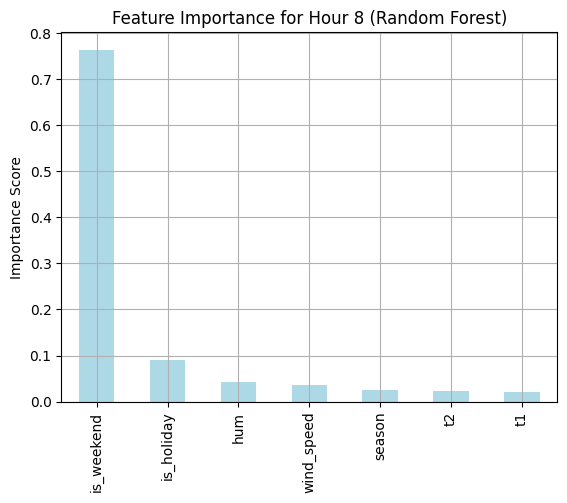

In [67]:
# 最も予測精度が高かった7時のモデルにおいて、特徴量の重要度を確認
_hour = 8
# _hourのデータを抽出
df_tmp = df.query(f'hour == {_hour}')

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）を使用
X = df_tmp[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday','season']]
y = df_tmp['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance for Hour 8 (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

All Hours: Mean Absolute Error: 143.30 Mean Squared Error: 63272.26 R2 Score: 0.95


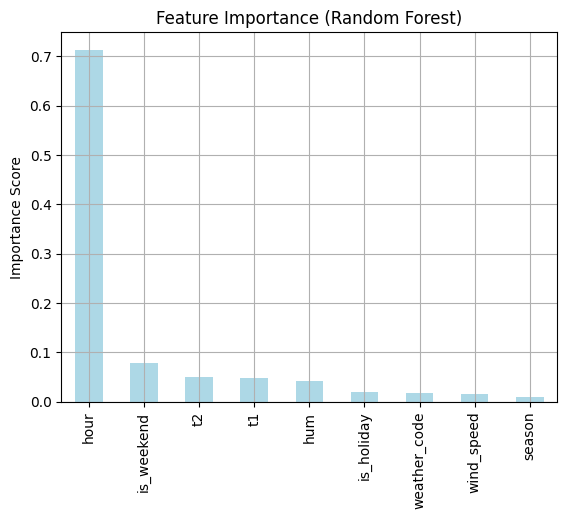

In [73]:
# 全時刻のデータを利用して、非線形モデルを作成し、特徴量の重要度を確認

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）、weather_code（天気コード）、hour（時間）を使用
X = df[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'season', 'weather_code', 'hour']]
y = df['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# テストデータで予測
y_pred = model.predict(X_test)
# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

In [69]:
# 4. 「現場の知恵」を特徴量として追加
# ルール1：通勤ラッシュの時間帯か？
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if x in [7,8,9,17,18,19] else 0)
# ルール2：サイクリングに最適な気温（例：15度〜25度）か？
df['is_pleasant_temp'] = df['t1'].apply(lambda x: 1 if 15 <= x <= 25 else 0)

features: ['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'season', 'weather_code', 'hour', 'is_rush_hour', 'is_pleasant_temp']
All Hours: Mean Absolute Error: 144.20 Mean Squared Error: 65135.51 R2 Score: 0.95


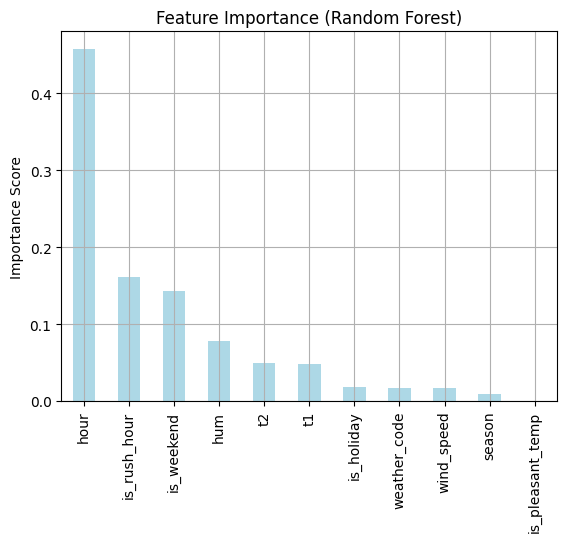

features: ['hum', 'wind_speed', 'is_weekend', 'is_holiday', 'season', 'weather_code', 'is_rush_hour', 'is_pleasant_temp']
All Hours: Mean Absolute Error: 434.47 Mean Squared Error: 374526.33 R2 Score: 0.69


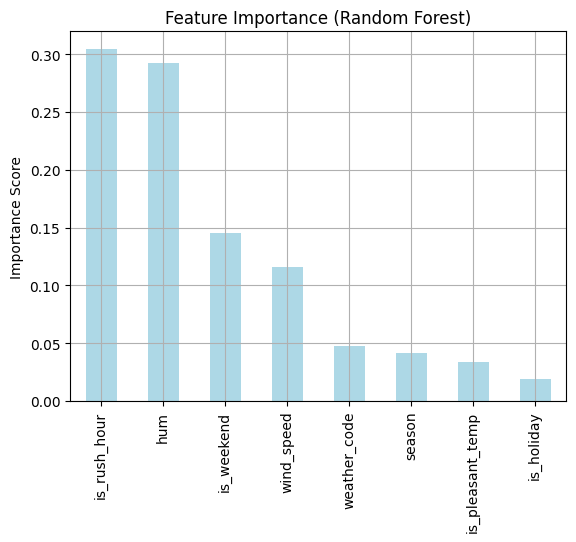

In [79]:
# 全時刻のデータを利用して、非線形モデルを作成し、特徴量の重要度を確認

# dfを学習用とテスト用に分割
# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）、weather_code（天気コード）、hour（時間）、is_rush_hour（通勤時間かどうか）、is_pleasant_temp（快適な気温かどうか）を使用
X = df[['t1', 't2', 'hum', 'wind_speed', 'is_weekend', 'is_holiday', 'season', 'weather_code', 'hour', 'is_rush_hour', 'is_pleasant_temp']]
y = df['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# テストデータで予測
y_pred = model.predict(X_test)
# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('features:', X.columns.tolist())
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

# 特徴量としてt1（気温）、t2（体感温度）、hum（湿度）、wind_speed（風速）、is_weekend（週末かどうか）、is_holiday（祝日かどうか）、season（季節）、weather_code（天気コード）、hour（時間）、is_rush_hour（通勤時間かどうか）、is_pleasant_temp（快適な気温かどうか）を使用
X = df[['hum', 'wind_speed', 'is_weekend', 'is_holiday', 'season', 'weather_code', 'is_rush_hour', 'is_pleasant_temp']]
y = df['cnt'] # 目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 非線形モデルを作成
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# テストデータで予測
y_pred = model.predict(X_test)
# 各種評価指標を計算
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('features:', X.columns.tolist())
print(f'All Hours: Mean Absolute Error: {mae:.2f} Mean Squared Error: {mse:.2f} R2 Score: {r2:.2f}')

# 特徴量の重要度を表示
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.grid()
plt.show()

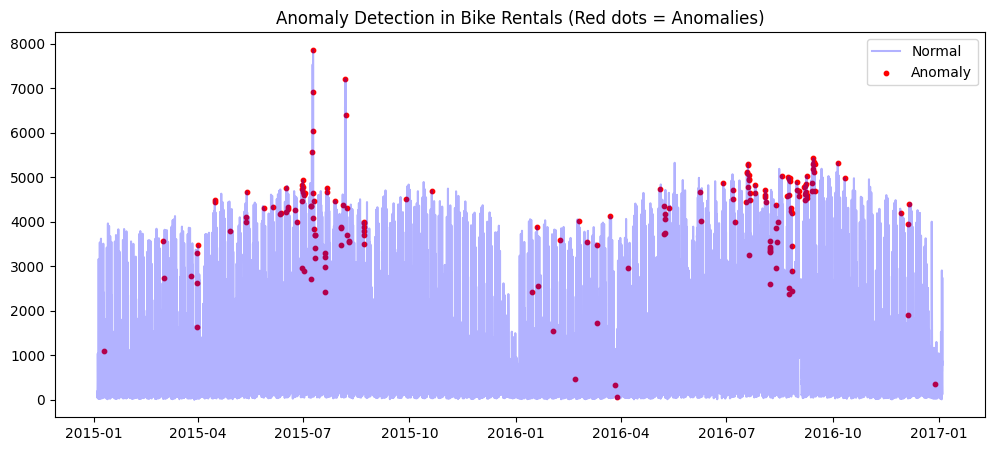

In [74]:
# 5. 異常検知 (Isolation Forest)
# 「通常ではありえない利用パターン」を自動で検出
features_iso = ['cnt', 't1', 'hum', 'wind_speed', 'hour', 'is_rush_hour']
iso_model = IsolationForest(contamination=0.01, random_state=42) # 上位1%を異常とする
df['anomaly'] = iso_model.fit_predict(df[features_iso])

# 異常値の可視化 (-1が異常)
anomalies = df[df['anomaly'] == -1]
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['cnt'], color='blue', label='Normal', alpha=0.3)
plt.scatter(anomalies['timestamp'], anomalies['cnt'], color='red', label='Anomaly', s=10)
plt.title('Anomaly Detection in Bike Rentals (Red dots = Anomalies)')
plt.legend()
plt.show()